# TEST image & coordinates grid rotation

In [1]:
import lsst.afw.geom as afwGeom
#import lsst.sphgeom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.geom as geom
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
import astropy.visualization as vis

Function rotate_exposure from DP02_14_Injecting_Synthetic_Sources - a modified version of [this code](https://github.com/lsst/atmospec/blob/1e7d6e8e5655cc13d71b21ba866001e6d49ee04e/python/lsst/atmospec/utils.py#L259-L301).

In [2]:
def rotate_exposure(exp, n_degrees):
    """Rotate an exposure by nDegrees clockwise.

    Parameters
    ----------
    exp : `lsst.afw.image.exposure.Exposure`
        The exposure to rotate
    n_degrees : `float`
        Number of degrees clockwise to rotate by

    Returns
    -------
    rotated_exp : `lsst.afw.image.exposure.Exposure`
        A copy of the input exposure, rotated by nDegrees
    """
    n_degrees = n_degrees % 360

    wcs = exp.getWcs()

    warper = afwMath.Warper('lanczos4')

    affine_rot_transform = geom.AffineTransform.makeRotation(n_degrees*geom.degrees)
    transform_p2top2 = afwGeom.makeTransform(affine_rot_transform)
    rotated_wcs = afwGeom.makeModifiedWcs(transform_p2top2, wcs, False)

    rotated_exp = warper.warpExposure(rotated_wcs, exp)
    return rotated_exp

I arbitrarily define an image 

In [3]:
dataId = {'instrument': 'LSSTCam-imSim', 'detector': 60, 'visit': 964209, 'band': 'g', 'physical_filter': 'r_sim_1.4'}

In [4]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
image = butler.get("calexp", dataId=dataId)

In [5]:
visitInfo = butler.get("calexp.visitInfo", dataId=dataId)
print(visitInfo)

VisitInfo(exposureTime=30, darkTime=30, date=2025-11-19T05:15:08.140899939, UT1=nan, ERA=2.38746 rad, boresightRaDec=(57.0910540010, -34.6558679005), boresightAzAlt=(238.3930420731, +80.9489061026), boresightAirmass=1.01108, boresightRotAngle=2.03788 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=964209, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)


In [6]:
bbox = image.getBBox()
wcs = image.getWcs()
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
c = SkyCoord(ra=center.getRa().asDegrees()*u.degree,
             dec=center.getDec().asDegrees()*u.degree, frame='icrs')
print("Image center RA in h:m:s format is:", c.ra.hms)
print("Image center De in deh:m:s format is:", c.dec)

Image center RA in h:m:s format is: hms_tuple(h=np.float64(3.0), m=np.float64(47.0), s=np.float64(21.00701989921518))
Image center De in deh:m:s format is: -34d01m23.96094562s


I define the coordinates of a clearly identifiable object in the field (a galaxy)

In [7]:
coord_gal = SkyCoord(
    ra = 56.9223016 * u.degree,  #3h 47m 41.35s
    dec = -33.9485169 * u.degree, #-33 56 54.66
    frame='icrs'
)

Plot of the selected field and object

<function matplotlib.pyplot.show(close=None, block=None)>

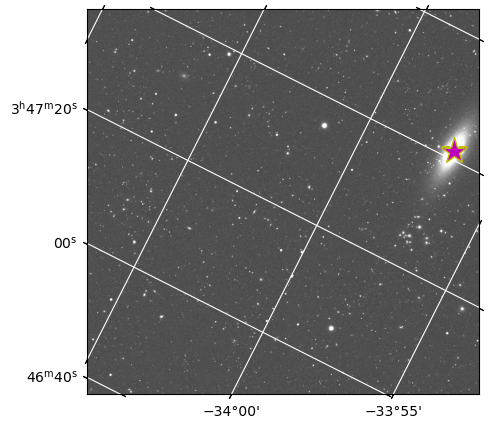

In [8]:
zscale = vis.ZScaleInterval()

fig = plt.figure(figsize=(10, 5))
wcs = WCS(image.getWcs().getFitsMetadata())
image_data = image.getImage().array
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
 
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image_data, cmap='gray', **limits)
ax.plot(*wcs.world_to_pixel(coord_gal), 'y*', markerfacecolor="m", ms=20, label="Gal. coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')
plt.show
#plt.savefig("original.png")

I rotate the field to have  North up and East at the left (so RA along x-axis and DEC along y-axis, with RA increasing to the left and Dec increasing towards the top

In [9]:
#How to retrieve rotation angle. da https://community.lsst.org/t/calexps-displayed-with-imshow-seem-offset-from-wcs-center/9475
#print(calexp.getInfo().getVisitInfo().boresightRotAngle.asDegrees())
rotationangle = image.getInfo().getVisitInfo().boresightRotAngle.asDegrees()
print("Image rotation angle = " + str(rotationangle) + " deg")

Image rotation angle = 116.76168911185 deg


In [10]:
myrotationangle = 360- rotationangle   # to "derotate" the field <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                                       # or simply  myrotationangle = -rotationangle
print("my rotation angle = " + str(myrotationangle))

my rotation angle = 243.23831088815


In [11]:
rotation_angle = myrotationangle #243
image_rotated = rotate_exposure(image, rotation_angle)

I check the center of the rotated images and I compare it with the original image center, it's the same

In [12]:
bbox_rotated = image_rotated.getBBox()
wcs_rotated = image_rotated.getWcs()
center_rotated = wcs_rotated.pixelToSky(bbox_rotated.centerX, bbox_rotated.centerY)
c_rotated = SkyCoord(ra=center_rotated.getRa().asDegrees()*u.degree,
             dec=center_rotated.getDec().asDegrees()*u.degree, frame='icrs')
print("Rotated Image center RA in h:m:s format is:", c_rotated.ra.hms)
print("Rotated Image center De in deh:m:s format is:", c_rotated.dec)
print("Image center RA in h:m:s format is:", c.ra.hms)
print("Image center De in deh:m:s format is:", c.dec)

Rotated Image center RA in h:m:s format is: hms_tuple(h=np.float64(3.0), m=np.float64(47.0), s=np.float64(21.001003828125988))
Rotated Image center De in deh:m:s format is: -34d01m23.88806291s
Image center RA in h:m:s format is: hms_tuple(h=np.float64(3.0), m=np.float64(47.0), s=np.float64(21.00701989921518))
Image center De in deh:m:s format is: -34d01m23.96094562s


In [13]:
print(wcs)
print(" --- ")
print(image.getWcs())
print(" --- ")
print(" --- ")
print(wcs_rotated)
print(" --- ")
print(image_rotated.getWcs())

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 56.8459142679398 -34.024349050437756 
CRPIX : 2076.313076 2120.4841499999998 
CD1_1 CD1_2  : 2.50295041419008e-05 4.96157569505408e-05 
CD2_1 CD2_2  : 4.9606774180512e-05 -2.501406312277e-05 
NAXIS : 0  0
 --- 
FITS standard SkyWcs:
Sky Origin: (56.8459142679, -34.0243490504)
Pixel Origin: (2075.31, 2119.48)
Pixel Scale: 0.200031 arcsec/pixel
 --- 
 --- 
FITS standard SkyWcs:
Sky Origin: (56.8459142679, -34.0243490504)
Pixel Origin: (-2826.93, 898.658)
Pixel Scale: 0.200031 arcsec/pixel
 --- 
FITS standard SkyWcs:
Sky Origin: (56.8459142679, -34.0243490504)
Pixel Origin: (-2826.93, 898.658)
Pixel Scale: 0.200031 arcsec/pixel


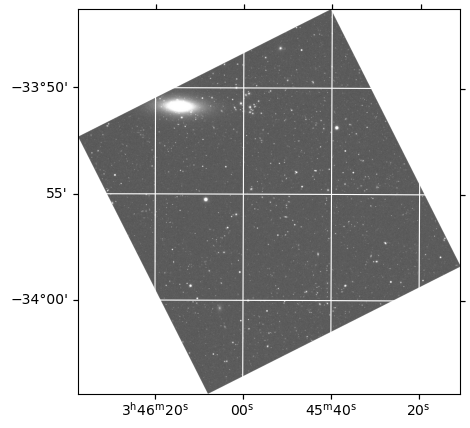

In [14]:
fig = plt.figure(figsize=(10, 5))
wcs_rotated = WCS(image_rotated.getWcs().getFitsMetadata())
image_rotated_data = image_rotated.getImage().array
limits_rotated = {"vmin": (_lims := zscale.get_limits(image_rotated_data))[0], "vmax": _lims[1]}
ax = fig.add_subplot(1, 1, 1, projection=wcs_rotated)
ax.imshow(image_rotated_data, cmap='gray', **limits_rotated)
#ax.plot(*wcs_rotated.world_to_pixel(coord_gal), 'y*', markerfacecolor="None", ms=20, label="Gal.coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')
plt.show()
#plt.savefig("rotated_1.png")

Something seems to be not correct: the image is rotated as I expected, the coordinates grid too, but the coordinates of the grid are wrong, the galaxy is not marked correctly, the marker falls at the right coordinates of the galaxy: Ra = 56.9223016 (3h 47m 41.35s), Dec = -33.9485169 (-33 56 54.66)

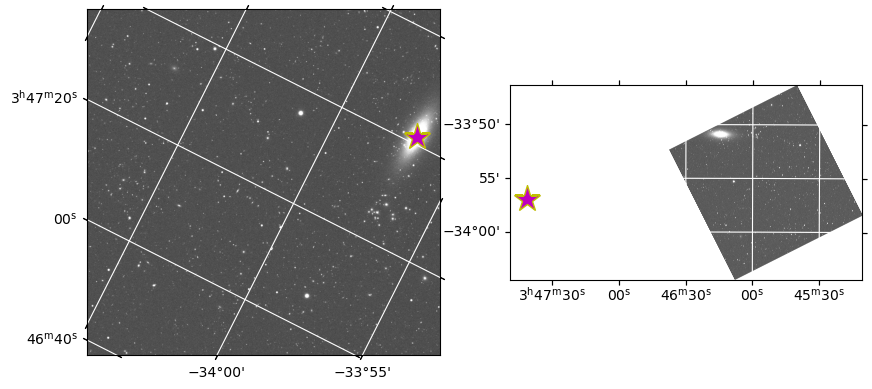

In [15]:
#plot of the original and rotated image side by side
fig = plt.figure(figsize=(10, 5))

wcs = WCS(image.getWcs().getFitsMetadata())
image_data = image.getImage().array
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}

wcs_rotated = WCS(image_rotated.getWcs().getFitsMetadata())
image_rotated_data = image_rotated.getImage().array
limits_rotated = {"vmin": (_lims := zscale.get_limits(image_rotated_data))[0], "vmax": _lims[1]}


ax = fig.add_subplot(1, 2, 1, projection=wcs)
ax.imshow(image_data, cmap='gray', **limits)
ax.plot(*wcs.world_to_pixel(coord_gal), 'y*', markerfacecolor="m", ms=20, label="Candidate transient coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')

ax = fig.add_subplot(1, 2, 2, projection=wcs_rotated)
ax.imshow(image_rotated_data, cmap='gray', **limits_rotated)
ax.plot(*wcs_rotated.world_to_pixel(coord_gal), 'y*', markerfacecolor="m", ms=20, label="Candidate transient coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')
plt.show()
#plt.savefig("rotated_2.png")

Let's try with another image

In [16]:
datasetRefs = butler.query_datasets(dataset_type='calexp', band='g', detector=175)#,
#                                    where='visit > 196000 and visit < 199000')
#for i, ref in enumerate(datasetRefs):
#    print(ref.dataId)

In [17]:
visitInfo = butler.get('calexp.visitInfo', dataId=datasetRefs[120].dataId)
print(visitInfo)
image =  butler.get('calexp', dataId=datasetRefs[7].dataId)

VisitInfo(exposureTime=30, darkTime=30, date=2022-09-19T06:57:52.262200094, UT1=nan, ERA=1.78359 rad, boresightRaDec=(65.5981640961, -32.0976113452), boresightAzAlt=(102.4935857883, +61.1576437060), boresightAirmass=1.13866, boresightRotAngle=0.0223384 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=194847, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)


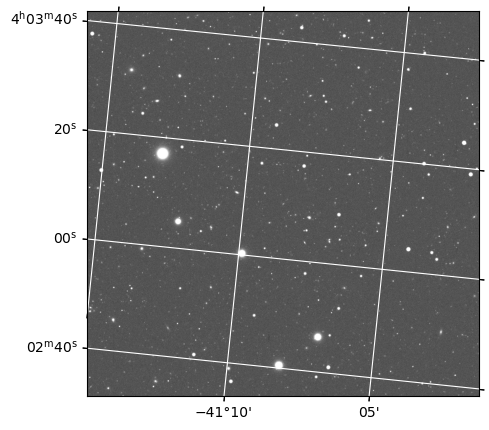

In [18]:
zscale = vis.ZScaleInterval()

fig = plt.figure(figsize=(10, 5))
wcs = WCS(image.getWcs().getFitsMetadata())
image_data = image.getImage().array
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
 
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image_data, cmap='gray', **limits)
#ax.plot(*wcs.world_to_pixel(coord_gal), 'y*', markerfacecolor="m", ms=20, label="Gal. coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')
plt.show()

In [19]:
rotationangle = image.getInfo().getVisitInfo().boresightRotAngle.asDegrees()
print("Image rotation angle = " + str(rotationangle) + " deg")

Image rotation angle = 97.1981199426989 deg


In [20]:
myrotationangle= -rotationangle 
print("MY Image rotation angle = " + str(myrotationangle) + " deg")
image_rotated = rotate_exposure(image, myrotationangle)

MY Image rotation angle = -97.1981199426989 deg


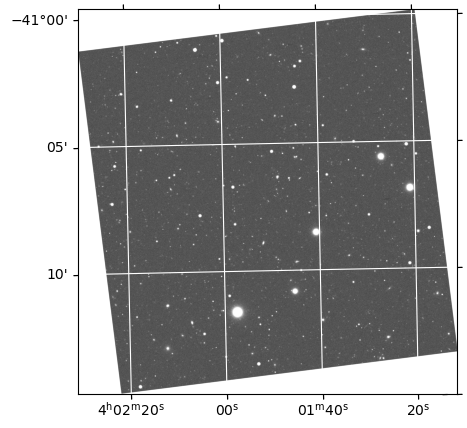

In [21]:
fig = plt.figure(figsize=(10, 5))
wcs_rotated = WCS(image_rotated.getWcs().getFitsMetadata())
image_rotated_data = image_rotated.getImage().array
limits_rotated = {"vmin": (_lims := zscale.get_limits(image_rotated_data))[0], "vmax": _lims[1]}
ax = fig.add_subplot(1, 1, 1, projection=wcs_rotated)
ax.imshow(image_rotated_data, cmap='gray', **limits_rotated)
#ax.plot(*wcs_rotated.world_to_pixel(coord_gal), 'y*', markerfacecolor="None", ms=20, label="Gal.coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')
plt.show()

In [22]:
image.getInfo().getVisitInfo()

VisitInfo(exposureTime=30, darkTime=30, date=2022-07-31T08:20:11.664000081, UT1=nan, ERA=1.28366 rad, boresightRaDec=(58.9318532652, -40.9859056211), boresightAzAlt=(119.4713896669, +44.2126146536), boresightAirmass=1.41203, boresightRotAngle=1.69643 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=159469, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)

It seems that the coordinates are not handled correctly: the orientation is fine but numbers are wrong. Or I'm doing something wrong...

I make a plot of the original and the rotated image  in pixels (see https://dp0-2.lsst.io/_static/nb_html/DP02_04b_Intermediate_Butler_Queries.html)

In [23]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (10.0, 10.0)

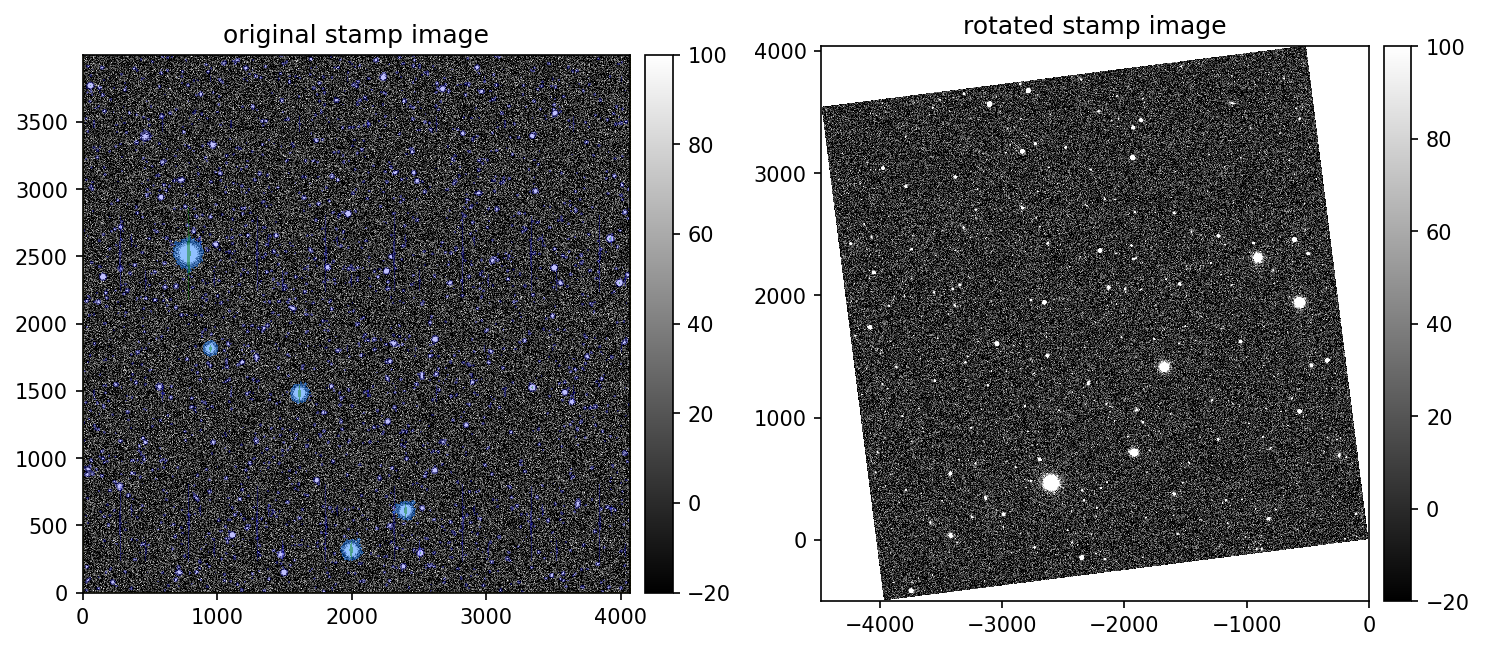

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', min=-20, max=100)
display0.mtv(image)
plt.title('original stamp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', min=-20, max=100)
display1.mtv(image_rotated.image)
plt.title('rotated stamp image')

plt.tight_layout()
plt.show()